# Build regression models to understand dollars per impression of ads (of climate and all ads)
Model captures the impressions/spend variable using as features:
* sentiment
* democratic party label
* delivery by region
* demographic distribution
* state of the candidate running the ad
* ad creation time? (maybe not super informative, as how long the ad ran for - but we don't have this info)

In [2]:
import pickle
from datetime import datetime
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':8})
matplotlib.rcParams['pdf.fonttype'] = 42

%matplotlib notebook

In [3]:
# load data
file_in = open('all_ads_labeled.pickle','rb')
dat = pickle.load(file_in)

print('number of ads',dat.shape)

# filter out nans in creative sentiment (e.g. they are probably videos), removes 4487 ads (0.74%)
dat = dat[~dat['ad_creative_body'].isna()]
# filter out ads which just have empty space as text, e.g '  ', removes 40 in total out of (602544)
dat = dat[dat['ad_creative_body'].str.strip() != '']
# filter out ads that do not have any targeting info (removes 138289 ads - 22.95% of all ads) - see analysis below
dat = dat[~((dat['demographic_distribution'].isna()) | (dat['delivery_by_region'].isna()))]
# remove ads where demographic_distribution = [{'percentage': '1'}], not sure what that means, removes 6 ads
dat = dat[dat['demographic_distribution'].map(lambda x: 1 if x == [{'percentage': '1'}] else 0) == 0]
# relabel Independents as Democrats - as the two independent politicians caucus with the Democrats
dat['party'].replace('Independent','Democrat',inplace=True)

# estimate sentiment of individual ads by scorign each sentence and taking the average compound score of sentences
sia = SentimentIntensityAnalyzer()
def estimate_sentiment(text_):
    i = 0
    comp = 0
    for sentence in nltk.sent_tokenize(text_):
        sentiment = sia.polarity_scores(sentence)
        comp += sentiment['compound']
        i += 1
    return(comp/i)

# add sentiment to the dataframe
dat['sentiment'] = dat['ad_creative_body'].map(lambda x: estimate_sentiment(x))

number of ads (602544, 17)


In [4]:
# remove all adds with low spend and low impressions

dat = dat[(dat['spend_lo'] != 0) & (dat['impressions_lo'] != 0)]

print('Final number of ads', dat.shape)

Final number of ads (139938, 18)


In [5]:
# construct feature vector for age features
age_feature_id = {'13-17':0, '18-24':1, '25-34':2, '35-44':3, '45-54':4, '55-64':5, '65+':6}
def create_age_features(demo_dist):
    # create empty array to house percentages for the 6 age groups
    demo_features = np.zeros(7)
    
    # one example of demographic features for 1 ad is:
    # [{'percentage': '0.070631', 'age': '18-24', 'gender': 'female'},
    # {'percentage': '0.339873', 'age': '35-44', 'gender': 'female'},
    # {'percentage': '0.408995', 'age': '25-34', 'gender': 'female'},
    # {'percentage': '0.002717', 'age': '35-44', 'gender': 'unknown'},
    # ...
    
    # iterate over demographic distributions
    for i in demo_dist:
        if i['age'] != 'Unknown': # disregard these when building age features
            demo_features[age_feature_id[i['age']]] += float(i['percentage'])
            
    # return rescaled features - to ensure its returnes summing to 1
    return list(demo_features/sum(demo_features))

# construct feature vector for gender features
gender_feature_id = {'male':0,'female':1}
def create_gender_features(demo_dist):
    # create empty array to house percentages for the 6 age groups
    demo_features = np.zeros(2)
    
    # one example of demographic features for 1 ad is:
    # [{'percentage': '0.070631', 'age': '18-24', 'gender': 'female'},
    # {'percentage': '0.339873', 'age': '35-44', 'gender': 'female'},
    # {'percentage': '0.408995', 'age': '25-34', 'gender': 'female'},
    # {'percentage': '0.002717', 'age': '35-44', 'gender': 'unknown'},
    # ...
    
    # iterate over demographic distributions
    for i in demo_dist:
        if i['gender'] != 'unknown': # disregard these when building gender features
            demo_features[gender_feature_id[i['gender']]] += float(i['percentage'])
            
    # return rescaled features - to ensure its returnes summing to 1
    return list(demo_features/sum(demo_features))

# construct region feature vector - using states as individual features
region_feature_id_ = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware',
'Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine',
'Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada',
'New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon',
'Pennsylvania','Rhode Island','South Dakota','South Carolina','Tennessee','Texas','Utah','Vermont','Virginia',
'Washington','Washington, District of Columbia','West Virginia','Wisconsin','Wyoming']
region_feature_id = dict(zip(region_feature_id_,range(51)))
region_feature_id['District of Columbia'] = 47
# sometimes DC is stored as 'District of Columbia', sometimes as 'Washington, District of Columbia' - fix this
def create_region_features(region_dist):
    # create empty array to house percentages for the 51 states (50 states + washington)
    region_features = np.zeros(51)
    
    # one example of region features for 1 ad is:
    # [{'percentage': '0.000295', 'region': 'Montana'},
    # {'percentage': '0.003836', 'region': 'Oklahoma'},
    # {'percentage': '0.006787', 'region': 'Nebraska'},
    # {'percentage': '0.004426', 'region': 'Nevada'},
    # {'percentage': '0.001475', 'region': 'New Hampshire'},
    # ...
    
    # iterate over region distributions
    good_regions = set(region_feature_id.keys()) # not sure why the bad regions are in the data
    # bad regions include 'Unknown','Baja California','Ontario','Yangon','British Columbia','Guaynabo','Caguas' ...
    for i in region_dist:
        if i['region'] in good_regions: # disregard these when building region features
            region_features[region_feature_id[i['region']]] += float(i['percentage'])
            
    # return rescaled features - to ensure its returnes summing to 1
    return list(region_features/sum(region_features))

# aggregating states into Democratic, Republican, or Swing state (less than 5% win margin in 2020 election)
# indexing ->  democratic: 0, republican: 1, swing: 2
region_agg_dict = {'Alabama':1,'Alaska':1,'Arizona':2,'Arkansas':1,'California':0,'Colorado':0,'Connecticut':0,'Delaware':0,
'Florida':2,'Georgia':2,'Hawaii':0,'Idaho':1,'Illinois':0,'Indiana':1,'Iowa':1,'Kansas':1,'Kentucky':1,'Louisiana':1,'Maine':0,
'Maryland':0,'Massachusetts':0,'Michigan':2,'Minnesota':0,'Mississippi':1,'Missouri':1,'Montana':1,'Nebraska':1,'Nevada':2,
'New Hampshire':0,'New Jersey':0,'New Mexico':0,'New York':0,'North Carolina':2,'North Dakota':1,'Ohio':1,'Oklahoma':1,'Oregon':0,
'Pennsylvania':2,'Rhode Island':0,'South Dakota':1,'South Carolina':1,'Tennessee':1,'Texas':1,'Utah':1,'Vermont':0,'Virginia':0,
'Washington':0,'Washington, District of Columbia':0,'West Virginia':1,'Wisconsin':2,'Wyoming':1,'District of Columbia':0}

def create_region_features_2(region_dist):
    # create empty array to house percentages for the 3 state groups (democrats, republicans, swing states)
    region_features = np.zeros(3)
    
    # one example of region features for 1 ad is:
    # [{'percentage': '0.000295', 'region': 'Montana'},
    # {'percentage': '0.003836', 'region': 'Oklahoma'},
    # {'percentage': '0.006787', 'region': 'Nebraska'},
    # {'percentage': '0.004426', 'region': 'Nevada'},
    # {'percentage': '0.001475', 'region': 'New Hampshire'},
    # ...
    
    # iterate over region distributions
    good_regions = set(region_agg_dict.keys()) # not sure why the bad regions are in the data
    # bad regions include 'Unknown','Baja California','Ontario','Yangon','British Columbia','Guaynabo','Caguas' ...
    for i in region_dist:
        if i['region'] in good_regions: # disregard these when building region features
            region_features[region_agg_dict[i['region']]] += float(i['percentage'])
            
    # return rescaled features - to ensure its returnes summing to 1
    return list(region_features/sum(region_features))

# create climate ad feature
def create_climate_feature(climate_label):
    if climate_label == 'climate':
        return 1
    else:
        return 0
    
def create_party_feature(party_label):
    if party_label == 'Democrat':
        return 0
    else:
        return 1

In [63]:
# plt.figure()
# ax = plt.subplot(1,2,1)
# plt.hist(dat[dat['party'] == 'Democrat']['test'],bins=np.logspace(0,4,20),color='blue')
# #plt.hist(dat[(dat['party'] == 'Democrat') & (dat['spend_lo'] != 0) & (dat['impressions_lo'] != 0)]['test'],bins=np.logspace(0,4,20),color='red',alpha=0.5)
# plt.hist(dat[(dat['party'] == 'Democrat') & (~dat['test'].between(10.08,10.10))]['test'],bins=np.logspace(0,4,20),color='red',alpha=0.5)
# #plt.hist(np.log(dat[dat['party'] == 'Democrat']['test']),bins=20)
# #plt.yscale('log')
# plt.xscale('log')
# ax = plt.subplot(1,2,2)
# #plt.hist(dat[dat['party'] == 'Republican']['test'],bins=np.logspace(0,4,20))
# plt.hist(np.log(dat[dat['party'] == 'Republican']['test']),bins=20)
# plt.yscale('log')
# #plt.xscale('log')
# plt.show()

# modeling of data - build one model for democrats and one for republicans

In [6]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

In [7]:
def construct_dataset_party(party):
    # construct dataframe for modeling (democrats)
    X_ = [] # variables
    Y_ = [] # labels
    # iterate over ads
    for i, ad in dat[dat['party'] == party].iterrows():
        # append to labels
        Y_.append(ad.impressions/ad.spend)

        # create variables for this ad - starting with gender
        var = create_gender_features(ad.demographic_distribution)
        # add age distribution
        var.extend(create_age_features(ad.demographic_distribution))
        # add sentiment
        var.append(ad.sentiment)
        # add region stuff - STATES
        #var.extend(create_region_features(ad.delivery_by_region))
        # add region stuff - TYPES of state (dem, rep, or swing states)
        var.extend(create_region_features_2(ad.delivery_by_region))
        # add climate label
        var.append(create_climate_feature(ad.label))

        # append variable list to X_D
        X_.append(var)

    # create dataframe
    #column_names = ['male_aud','female_aud','13-17','18-24','25-34','35-44',
    #                '45-54','55-64','65+','sentiment']# + region_feature_id_

    column_names = ['male_aud', 'female_aud', '13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+',
                    'sentiment', 'democrat_states', 'republican_states', 'swing_states', 'climate_label']

    # create dataframe
    X_ = np.array(X_)
    Y_ = np.array(Y_)
    # min-max labels
    #Y_ = (np.array(Y_) - min(Y_)) / (max(Y_) - min(Y_))
    
    return X_, Y_, column_names

def construct_climate_dataset():
    # construct dataframe for modeling (democrats)
    X_ = [] # variables
    Y_ = [] # labels
    # iterate over ads
    for i, ad in dat[(dat['label'] == 'climate')].iterrows():
        # append to labels
        Y_.append(ad.impressions/ad.spend)

        # create variables for this ad - starting with gender
        var = create_gender_features(ad.demographic_distribution)
        # add age distribution
        var.extend(create_age_features(ad.demographic_distribution))
        # add sentiment
        var.append(ad.sentiment)
        # add region stuff - STATES
        #var.extend(create_region_features(ad.delivery_by_region))
        # add region stuff - TYPES of state (dem, rep, or swing states)
        var.extend(create_region_features_2(ad.delivery_by_region))
        # add info about sender of climate ad R or D
        var.append(create_party_feature(ad.party))

        # append variable list to X_D
        X_.append(var)

    column_names = ['male_aud', 'female_aud', '13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+',
                    'sentiment', 'democrat_states', 'republican_states', 'swing_states', 'party']

    # create dataframe
    X_ = np.array(X_)
    Y_ = np.array(Y_)
    
    return X_, Y_, column_names

# define some functions for building linear models
def bootstrap_sample(n): 
    return(np.random.randint(low = 0, high = n, size = n))

def lin_reg(x_, y_):
    lm = LinearRegression(fit_intercept=True, n_jobs=-1)
    model = lm.fit(x_, y_)
    return model.coef_, model.intercept_, model.score(x_, y_), pearsonr(y_,model.predict(x_))[0]
    
def lasso_reg(x_, y_, a_):
    lm = Lasso(fit_intercept=True, alpha = a_, max_iter = 10000)
    model = lm.fit(x_, y_)
    return model.coef_, model.intercept_, model.score(x_, y_), pearsonr(y_,model.predict(x_))[0]

def bootstrap(XX, YY, samples = 100, standardize = True, a_ = 1):
    
    # do bootstrapping
    n = len(XX)
    
    # calculate over bootstrap samples
    coef = []
    intercept = []
    r2_score = []
    r_score = []
    for i in range(samples):
        if i % 100 == 0:
            print('%d/%d' % (i,samples))
        s = bootstrap_sample(n)
        X_bootstrap = XX[s]
        Y_bootstrap = YY[s]

        # should data samples be normalized?
        if standardize == True:
            # calculate mean and std
            mean_ = np.mean(X_bootstrap, axis=0)
            std_ = np.std(X_bootstrap, ddof=1, axis=0)
            # normalize data set
            X_bootstrap = (X_bootstrap - mean_)/std_
        
        #coef_, intercept_, score_, r_ = lin_reg(X_bootstrap, Y_bootstrap)
        coef_, intercept_, score_, r_ = lasso_reg(X_bootstrap, Y_bootstrap, a_)
            
        coef.append(coef_)
        intercept.append(intercept_)
        r2_score.append(score_)
        r_score.append(r_)
        
    return np.array(coef), np.array(intercept), np.array(r2_score), np.array(r_score)

In [8]:
# load ads for Democrats 
X_D, Y_D, column_names = construct_dataset_party('Democrat')
# load ads for Republicans
X_R, Y_R, column_names = construct_dataset_party('Republican')

coef_D, intercept_D, r2_D, r_D = bootstrap(X_D, Y_D, samples = 100, standardize = True, a_ = 0.01)
coef_R, intercept_R, r2_R, r_R = bootstrap(X_R, Y_R, samples = 100, standardize = True, a_ = 0.01)

print('r2_D =',round(np.mean(r2_D),3),'r_D =',round(np.mean(r_D),3))
print('r2_R =',round(np.mean(r2_R),3),'r_R =',round(np.mean(r_R),3))

0/100
0/100
r2_D = 0.227 r_D = 0.476
r2_R = 0.088 r_R = 0.297


__results__
* Lasso ($\alpha = 0.01$), democrat ads, $r^2 = 0.227, r = 0.476$
* Lasso ($\alpha = 0.01$), republican ads, $r^2 = 0.088, r = 0.297$
* LM, democrat ads, $r^2 = 0.227, r = 0.476$
* LM, republican ads, $r^2 = 0.088, r = 0.297$

In [9]:
column_relabels = {'male_aud':'Male aud.','female_aud':'Female aud.','sentiment':'Sentiment',
         'democrat_states':'Democrat states','republican_states':'Republican states',
          'swing_states':'Swing states','climate_label':'Climate ads','party':'Republican ad'}

<IPython.core.display.Javascript object>


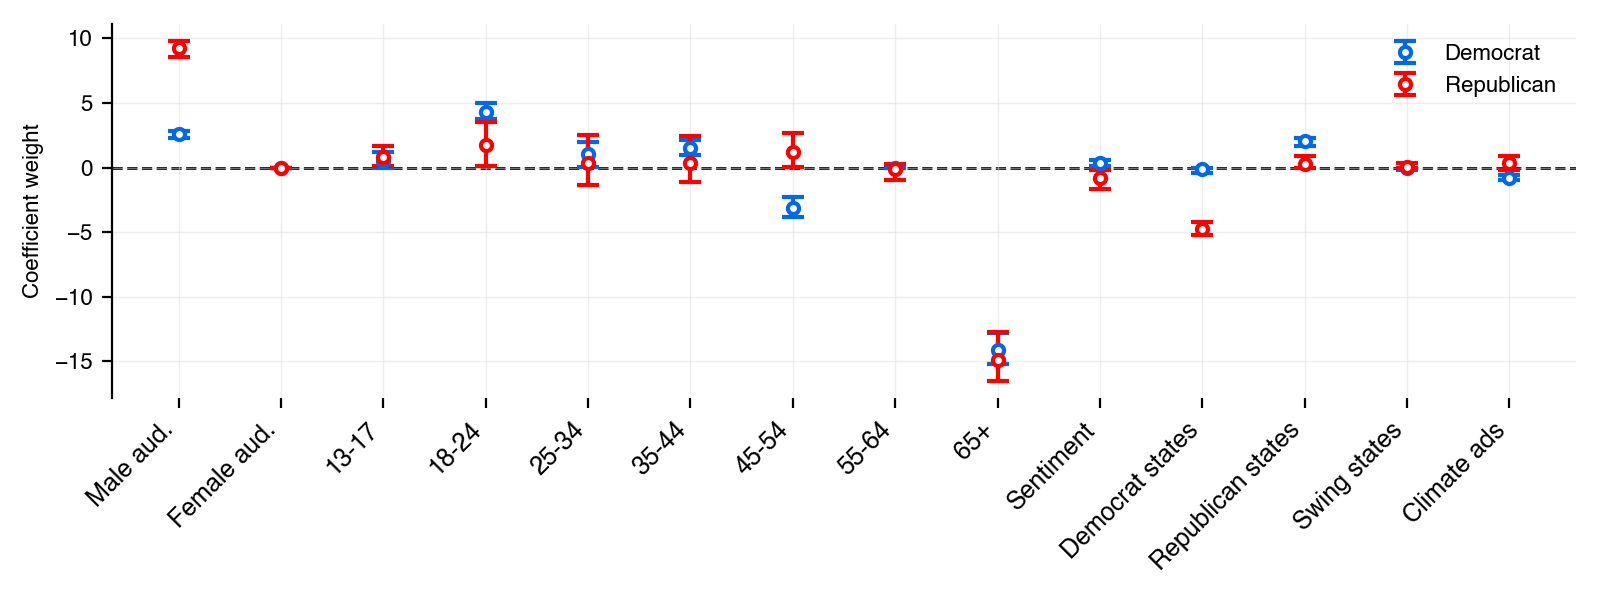

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [10]:
plt.figure(figsize=(8,3))
ax = plt.subplot(111)

# estimate errorbars
errors_D = np.vstack([np.abs(np.mean(coef_D,axis=0)-np.percentile(coef_D,2.5,axis=0)),
                      np.abs(np.mean(coef_D,axis=0)-np.percentile(coef_D,97.5,axis=0))])

errors_R = np.vstack([np.abs(np.mean(coef_R,axis=0)-np.percentile(coef_R,2.5,axis=0)),
                      np.abs(np.mean(coef_R,axis=0)-np.percentile(coef_R,97.5,axis=0))])

# plot errorbars
plt.errorbar(range(coef_D.shape[1]),np.mean(coef_D,axis=0),fmt='o',color='#0068ea',markerfacecolor='white',
            yerr=errors_D,capsize=4,ecolor='#0068ea',zorder=2,ms=4,mew=1.5,label='Democrat')

plt.errorbar(range(coef_R.shape[1]),np.mean(coef_R,axis=0),fmt='o',color='red',markerfacecolor='white',
            yerr=errors_R,capsize=4,ecolor='red',zorder=2,ms=4,mew=1.5,label='Republican')

plt.axhline(y = 0,ls='--',color='black',lw=1,zorder=1)

plt.ylabel('Coefficient weight')
plt.xticks(range(len(column_names)),[column_relabels.get(c,c) for c in column_names],
           weight='bold',rotation=45,ha='right',fontsize=9)
plt.legend(loc=0,frameon=False)

ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.right.set_visible(False)
plt.grid(True,lw=0.5,color='#dcdcdc',alpha=0.5,zorder=1)

plt.tight_layout()
#plt.savefig('/Users/vsek/Dropbox/ITU/Projects/climate-ads/model-democrats.pdf')
#plt.savefig('/Users/vsek/Dropbox/ITU/Projects/climate-ads/model-republican.pdf')
plt.savefig('/Users/vsek/Dropbox/ITU/Projects/climate-ads/model-individual-models-new.pdf')
plt.show()

## models for <font color='gree'>climate </font> advertisement

In [11]:
# load all climate ads
X_C, Y_C, column_names = construct_climate_dataset()

coef_C, intercept_C, r2_C, r_C = bootstrap(X_C, Y_C, samples = 1000, standardize = True, a_ = 0.01)

print('r2_C =',round(np.mean(r2_C),3),'r_C =',round(np.mean(r_C),3))

0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
r2_C = 0.272 r_C = 0.521


<IPython.core.display.Javascript object>


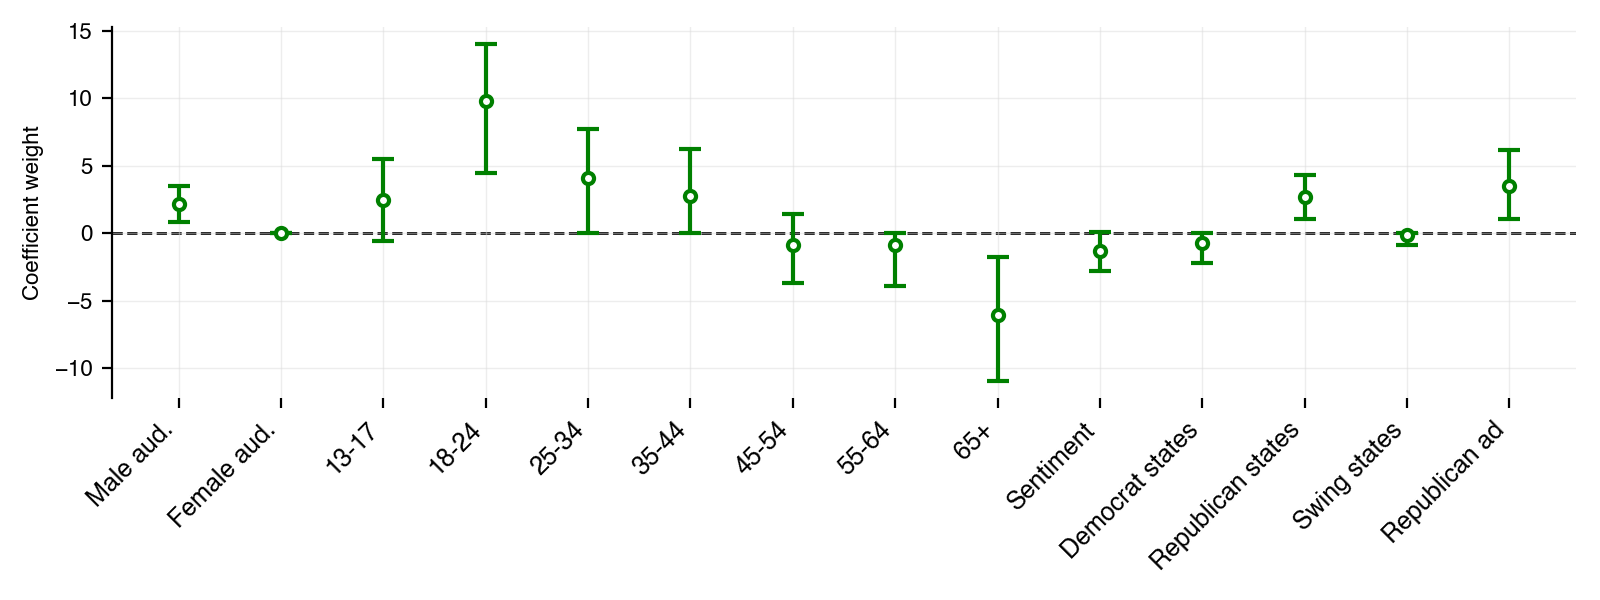

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [13]:
plt.figure(figsize=(8,3))
ax = plt.subplot(111)

# estimate errorbars
errors_C = np.vstack([np.abs(np.mean(coef_C,axis=0)-np.percentile(coef_C,2.5,axis=0)),
                      np.abs(np.mean(coef_C,axis=0)-np.percentile(coef_C,97.5,axis=0))])

# plot errorbars
plt.errorbar(range(coef_C.shape[1]),np.mean(coef_C,axis=0),fmt='o',color='green',markerfacecolor='white',
            yerr=errors_C,capsize=4,ecolor='green',zorder=2,ms=4,mew=1.5)

plt.axhline(y = 0,ls='--',color='black',lw=1,zorder=1)

plt.ylabel('Coefficient weight')
plt.xticks(range(len(column_names)),[column_relabels.get(c,c) for c in column_names],
           weight='bold',rotation=45,ha='right',fontsize=9)

ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.right.set_visible(False)
plt.grid(True,lw=0.5,color='#dcdcdc',alpha=0.5,zorder=1)

plt.tight_layout()
plt.savefig('/Users/vsek/Dropbox/ITU/Projects/climate-ads/model-climate_new.pdf')
plt.show()

# vertical plotting

<IPython.core.display.Javascript object>


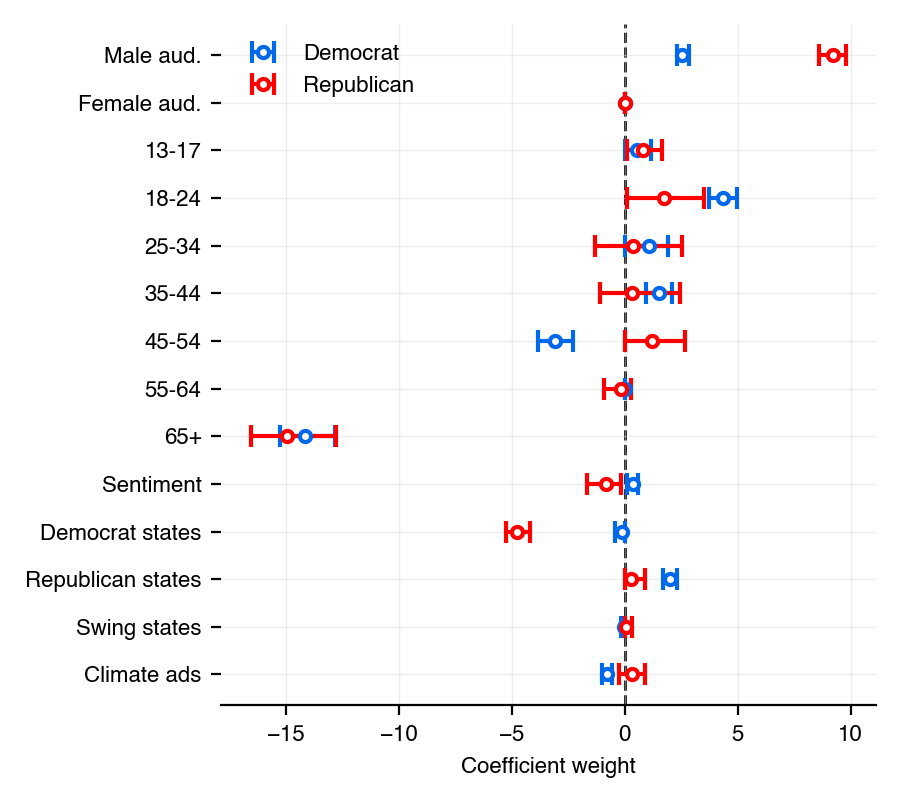

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [38]:
column_names = ['male_aud', 'female_aud', '13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+',
                    'sentiment', 'democrat_states', 'republican_states', 'swing_states', 'climate_label']

plt.figure(figsize=(4.5,4))
ax = plt.subplot(111)

# estimate errorbars
errors_D = np.vstack([np.abs(np.mean(coef_D,axis=0)-np.percentile(coef_D,2.5,axis=0)),
                      np.abs(np.mean(coef_D,axis=0)-np.percentile(coef_D,97.5,axis=0))])

errors_R = np.vstack([np.abs(np.mean(coef_R,axis=0)-np.percentile(coef_R,2.5,axis=0)),
                      np.abs(np.mean(coef_R,axis=0)-np.percentile(coef_R,97.5,axis=0))])

# plot errorbars
plt.errorbar(np.mean(coef_D,axis=0),range(coef_D.shape[1]),fmt='o',color='#0068ea',markerfacecolor='white',
            xerr=errors_D,capsize=4,ecolor='#0068ea',zorder=2,ms=4,mew=1.5,label='Democrat')

plt.errorbar(np.mean(coef_R,axis=0),range(coef_R.shape[1]),fmt='o',color='red',markerfacecolor='white',
            xerr=errors_R,capsize=4,ecolor='red',zorder=2,ms=4,mew=1.5,label='Republican')

plt.axvline(x = 0,ls='--',color='black',lw=1,zorder=1)

plt.xlabel('Coefficient weight')
plt.yticks(range(len(column_names)),[column_relabels.get(c,c) for c in column_names],
           weight='bold',rotation=0,ha='right',fontsize=8)
plt.legend(loc=0,frameon=False)

ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(True)
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.invert_yaxis()
plt.grid(True,lw=0.5,color='#dcdcdc',alpha=0.5,zorder=1)

plt.tight_layout()
#plt.savefig('/Users/vsek/Dropbox/ITU/Projects/climate-ads/model-democrats.pdf')
#plt.savefig('/Users/vsek/Dropbox/ITU/Projects/climate-ads/model-republican.pdf')
plt.savefig('/Users/vsek/Dropbox/ITU/Projects/climate-ads/model-individual-models-vertical.pdf')
plt.show()

<IPython.core.display.Javascript object>


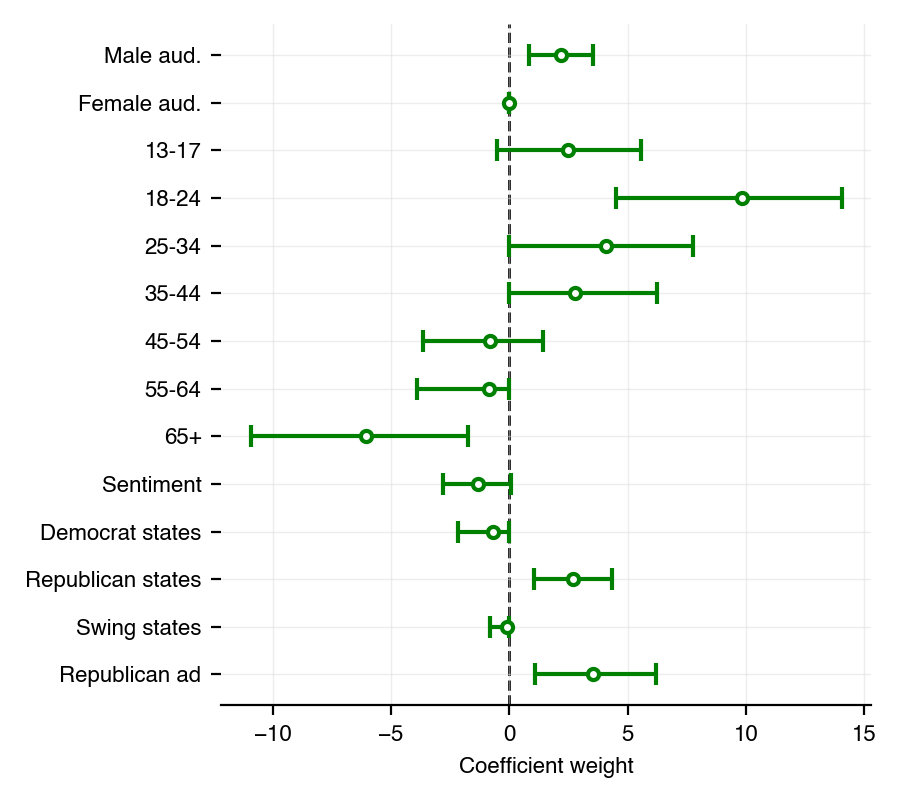

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [32]:
plt.figure(figsize=(4.5,4))
ax = plt.subplot(111)

# estimate errorbars
errors_C = np.vstack([np.abs(np.mean(coef_C,axis=0)-np.percentile(coef_C,2.5,axis=0)),
                      np.abs(np.mean(coef_C,axis=0)-np.percentile(coef_C,97.5,axis=0))])

# plot errorbars
plt.errorbar(np.mean(coef_C,axis=0),range(coef_C.shape[1]),fmt='o',color='green',markerfacecolor='white',
            xerr=errors_C,capsize=4,ecolor='green',zorder=2,ms=4,mew=1.5)

plt.axvline(x = 0,ls='--',color='black',lw=1,zorder=1)

plt.xlabel('Coefficient weight',fontsize=8)
plt.yticks(range(len(column_names)),[column_relabels.get(c,c) for c in column_names],
           weight='bold',rotation=0,ha='right',fontsize=8)

ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(True)
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)

plt.grid(True,lw=0.5,color='#dcdcdc',alpha=0.5,zorder=1)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('/Users/vsek/Dropbox/ITU/Projects/climate-ads/model-climate-vertical.pdf')
plt.show()

# misc
__are ads that have no demographic distribution or region info different from ads that have that info?__
<br />
* Check this in terms of republican / democratic split
* impressions/spend 
* and ad_creation_time

In [57]:
missing_info = dat[(dat['demographic_distribution'].isna()) | (dat['delivery_by_region'].isna())]
have_info = dat[~((dat['demographic_distribution'].isna()) | (dat['delivery_by_region'].isna()))]

<IPython.core.display.Javascript object>


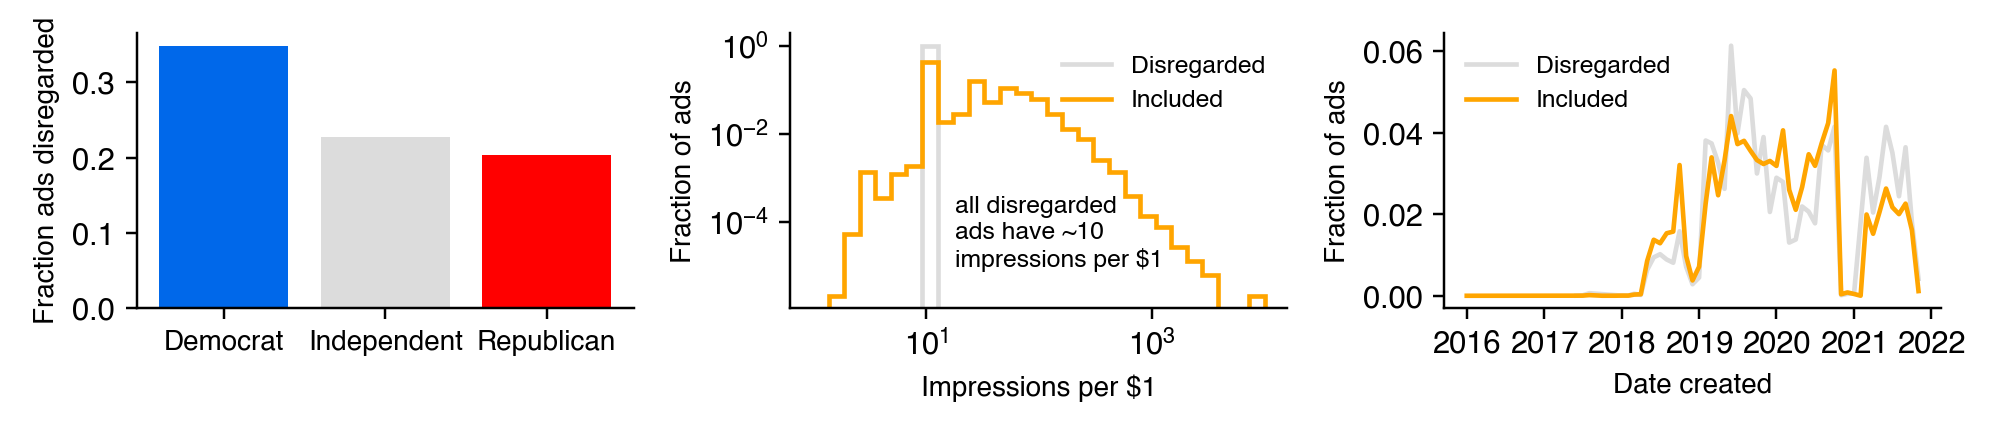

In [145]:
c_miss = Counter(missing_info['party'])
c_have = Counter(have_info['party'])

plt.figure(figsize=(9,2))
# -------------------- who are ads disregarded from
ax = plt.subplot(131)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
i = 0
colors = {'Democrat':'#0068ea','Independent':'#dcdcdc','Republican':'red'}
for p in ['Democrat','Independent','Republican']:
    plt.bar(i,c_miss[p]/c_have[p],color=colors[p])
    i += 1
plt.xticks(range(3),['Democrat','Independent','Republican'],fontsize=9)
plt.ylabel('Fraction ads disregarded',fontsize=9)

# -------------------- anything special in impressions/spend for disregarded ads
ax = plt.subplot(132)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

v_h, b = np.histogram(have_info['impressions']/have_info['spend'],bins=np.logspace(0,4,30))
v_m, b = np.histogram(missing_info['impressions']/missing_info['spend'],bins=np.logspace(0,4,30))
plt.stairs(v_m/sum(v_m),b,color='#dcdcdc',label='Disregarded',lw=1.5)
plt.stairs(v_h/sum(v_h),b,color='orange',label='Included',lw=1.5)
plt.legend(loc=0,frameon=False,fontsize=8)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Impressions per $1',fontsize=9)
plt.ylabel('Fraction of ads',fontsize=9)
plt.text(18,1e-5,'all disregarded\nads have ~10\nimpressions per $1',fontsize=8)

# -------------------- when were these ads created - any strange things here?
ax = plt.subplot(133)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

t,v = zip(*sorted(Counter(missing_info['ad_creation_time'].map(lambda x: datetime(x.year,x.month,1))).items()))
plt.plot(t,np.array(v)/sum(v),color='#dcdcdc',lw=1.5,label='Disregarded')
t,v = zip(*sorted(Counter(have_info['ad_creation_time'].map(lambda x: datetime(x.year,x.month,1))).items()))
plt.plot(t,np.array(v)/sum(v),color='orange',lw=1.5,label='Included')
plt.legend(loc=0,frameon=False,fontsize=8)
plt.xlabel('Date created',fontsize=9)
plt.ylabel('Fraction of ads',fontsize=9)

plt.tight_layout()
plt.savefig('ads_with_missing_demographics.png',dpi=300)
plt.show()